In [0]:
import torch
from torch import nn
import torchvision as tv

Используя сверточные слои и архитектуру получите на fashion mnist качество не ниже 89,5%


In [0]:
import time
import matplotlib.pyplot as plt

In [0]:
Fmnist_train = tv.datasets.FashionMNIST('.', train=True, transform=tv.transforms.ToTensor(), download=True)
Fmnist_test  = tv.datasets.FashionMNIST('.', train=False, transform=tv.transforms.ToTensor(), download=True)

In [0]:
labels_f={0:	'T-shirt/top',
1:	'Trouser',
2:	'Pullover',
3:	'Dress',
4:	'Coat',
5:	'Sandal',
6:	'Shirt',
7:	'Sneaker',
8:	'Bag',
9	:'Ankle boot'}

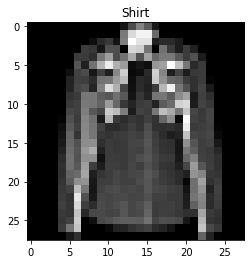

In [96]:
#Fmnist_train[0][0].reshape(28,28)#.shape
i=135
plt.title(labels_f[Fmnist_test[i][1]])
plt.imshow(Fmnist_test[i][0].numpy().reshape((28,28)), cmap='gray')

In [0]:
#Option I: LeNet
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(6, 12, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Flatten(),
    nn.Linear(300, 80),
    nn.ReLU(),
    nn.Linear(80, 10)
)

loss = torch.nn.CrossEntropyLoss(reduction='sum')
#trainer = torch.optim.Adam(model.parameters(), lr=0.001)
trainer = torch.optim.Adam(model.parameters())

In [0]:
#Option II: LeNet Another classification head
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(6, 12, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Flatten(),

    #torch.nn.BatchNorm1d(num_features=300),
    #torch.nn.Dropout(0.3),
    torch.nn.Linear(300, 150),
    torch.nn.ReLU(),

    #torch.nn.BatchNorm1d(num_features=150),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(150, 80),
    torch.nn.ReLU(),

    #torch.nn.BatchNorm1d(num_features=80),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(80, 10)
)

loss = torch.nn.CrossEntropyLoss(reduction='sum')
#trainer = torch.optim.Adam(model.parameters(), lr=0.001)
trainer = torch.optim.Adam(model.parameters())


In [39]:
X = Fmnist_train[0][0]
X = X.reshape(1, 1, 28, 28)
print(X.shape)
for l in model:
    X = l(X)
    print("Layer {}. X shape: {}".format(l, X.shape))

torch.Size([1, 1, 28, 28])
Layer Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)). X shape: torch.Size([1, 6, 28, 28])
Layer ReLU(). X shape: torch.Size([1, 6, 28, 28])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 6, 14, 14])
Layer Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1)). X shape: torch.Size([1, 12, 10, 10])
Layer ReLU(). X shape: torch.Size([1, 12, 10, 10])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 12, 5, 5])
Layer Flatten(). X shape: torch.Size([1, 300])
Layer Linear(in_features=300, out_features=150, bias=True). X shape: torch.Size([1, 150])
Layer ReLU(). X shape: torch.Size([1, 150])
Layer Dropout(p=0.2, inplace=False). X shape: torch.Size([1, 150])
Layer Linear(in_features=150, out_features=80, bias=True). X shape: torch.Size([1, 80])
Layer ReLU(). X shape: torch.Size([1, 80])
Layer Dropout(p=0.2, inplace=False). X shape: torch.Size([

In [0]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [41]:
print(torch.cuda.is_available(), dev)

False cpu


In [0]:
# Не везет

In [0]:
model = model.to(dev)

In [0]:
train, test = torch.utils.data.DataLoader(Fmnist_train, 256, shuffle=True), torch.utils.data.DataLoader(Fmnist_test, 256)

In [51]:
num_epochs = 15
for epoch in range(0, num_epochs):
    start, train_loss, train_acc, train_n, test_loss, test_acc, test_n = time.time(), 0., 0., 0, 0., 0., 0
    
    model.train()
    for X, y in train:
        trainer.zero_grad()
        y_hat = model.forward(X)
        l = loss(y_hat, y)
        l.backward()
        trainer.step()
        train_loss += l.item()
        train_acc += (y_hat.argmax(dim=1) == y).sum().item()
        train_n += len(X)
    
    model.eval()
    for X, y in test:
        y_hat = model.forward(X)
        l = loss(y_hat, y)
        test_loss += l.item()
        test_acc += (y_hat.argmax(dim=1) == y).sum().item()
        test_n += len(X)   
        
    print("""epoch {}, taked: {:.3f}
train -> loss: {:.3f}, acc: {:.3f}
test -> loss: {:.3f}, acc: {:.3f}
""".format(epoch, time.time() - start, train_loss / train_n, train_acc / train_n,
       test_loss / test_n, test_acc / test_n))


epoch 0, taked: 21.217
train -> loss: 0.269, acc: 0.901
test -> loss: 0.315, acc: 0.887

epoch 1, taked: 21.672
train -> loss: 0.262, acc: 0.905
test -> loss: 0.288, acc: 0.896

epoch 2, taked: 21.155
train -> loss: 0.260, acc: 0.904
test -> loss: 0.285, acc: 0.896

epoch 3, taked: 21.216
train -> loss: 0.256, acc: 0.905
test -> loss: 0.288, acc: 0.895

epoch 4, taked: 21.194
train -> loss: 0.252, acc: 0.906
test -> loss: 0.284, acc: 0.898

epoch 5, taked: 21.147
train -> loss: 0.249, acc: 0.907
test -> loss: 0.280, acc: 0.901

epoch 6, taked: 21.051
train -> loss: 0.244, acc: 0.909
test -> loss: 0.282, acc: 0.897

epoch 7, taked: 20.969
train -> loss: 0.241, acc: 0.912
test -> loss: 0.278, acc: 0.900

epoch 8, taked: 20.892
train -> loss: 0.237, acc: 0.913
test -> loss: 0.273, acc: 0.902

epoch 9, taked: 20.757
train -> loss: 0.234, acc: 0.914
test -> loss: 0.275, acc: 0.902

epoch 10, taked: 20.791
train -> loss: 0.232, acc: 0.913
test -> loss: 0.281, acc: 0.899

epoch 11, taked: 20.

In [97]:
#y_pred=torch.Tensor([1], dtypes=torch.int64)
y_pred=torch.zeros((1), dtype=torch.int64)
y_true=torch.zeros((1), dtype=torch.int64)
model.eval()
for X, y in test:
  #pass
  #y_hat = model.forward(X)
  y_hat = model(X)
  #print(y_pred.shape, torch.argmax(y_hat, dim=1).shape)
  pred_int=torch.argmax(y_hat, dim=1)
  y_pred=torch.cat((y_pred, pred_int), axis=0)
  y_true=torch.cat((y_true, y), axis=0)
y_pred=y_pred[1:]
y_true=y_true[1:]
len(y_pred), y_pred
#for i in test:
#  print(i[1])

(10000, tensor([9, 2, 1,  ..., 8, 1, 5]))

In [98]:
print('validation accuracy=',(y_pred == y_true).sum().item()/len(y_true))

validation accuracy= 0.9001


In [0]:
#list(labels_f.values())

In [103]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred  , target_names=list(labels_f.values()), digits=2))
print(confusion_matrix(y_true, y_pred,))#, labels=list(labels_f.values())))

              precision    recall  f1-score   support

 T-shirt/top       0.83      0.89      0.85      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.81      0.87      0.84      1000
       Dress       0.91      0.90      0.91      1000
        Coat       0.85      0.81      0.83      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.75      0.69      0.71      1000
     Sneaker       0.92      0.98      0.95      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.98      0.94      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

[[885   0  17  11   4   2  77   0   4   0]
 [  3 978   0  14   1   0   2   0   2   0]
 [ 15   1 867   9  46   0  61   0   1   0]
 [ 20   4  10 904  28   0  30   0   4   0]
 [  1   0  97  31 807   1  61   0   2   0]
 [  0   0   0   0   0 966 

In [0]:
# "Shirt" определяется хуже всего
#конец решения

In [100]:
#Смотрю на футболки, определившиеся не как футболки
shirt_arr=[]#n=0
shirt_wrong_ind=[]
for i in range(len(y_true.cpu())):
    if y_true[i]==6:
      shirt_arr.append(i)
      if y_true[i]!=y_pred[i]:
        shirt_wrong_ind.append(i)
len(shirt_arr), len(shirt_wrong_ind)

(1000, 315)

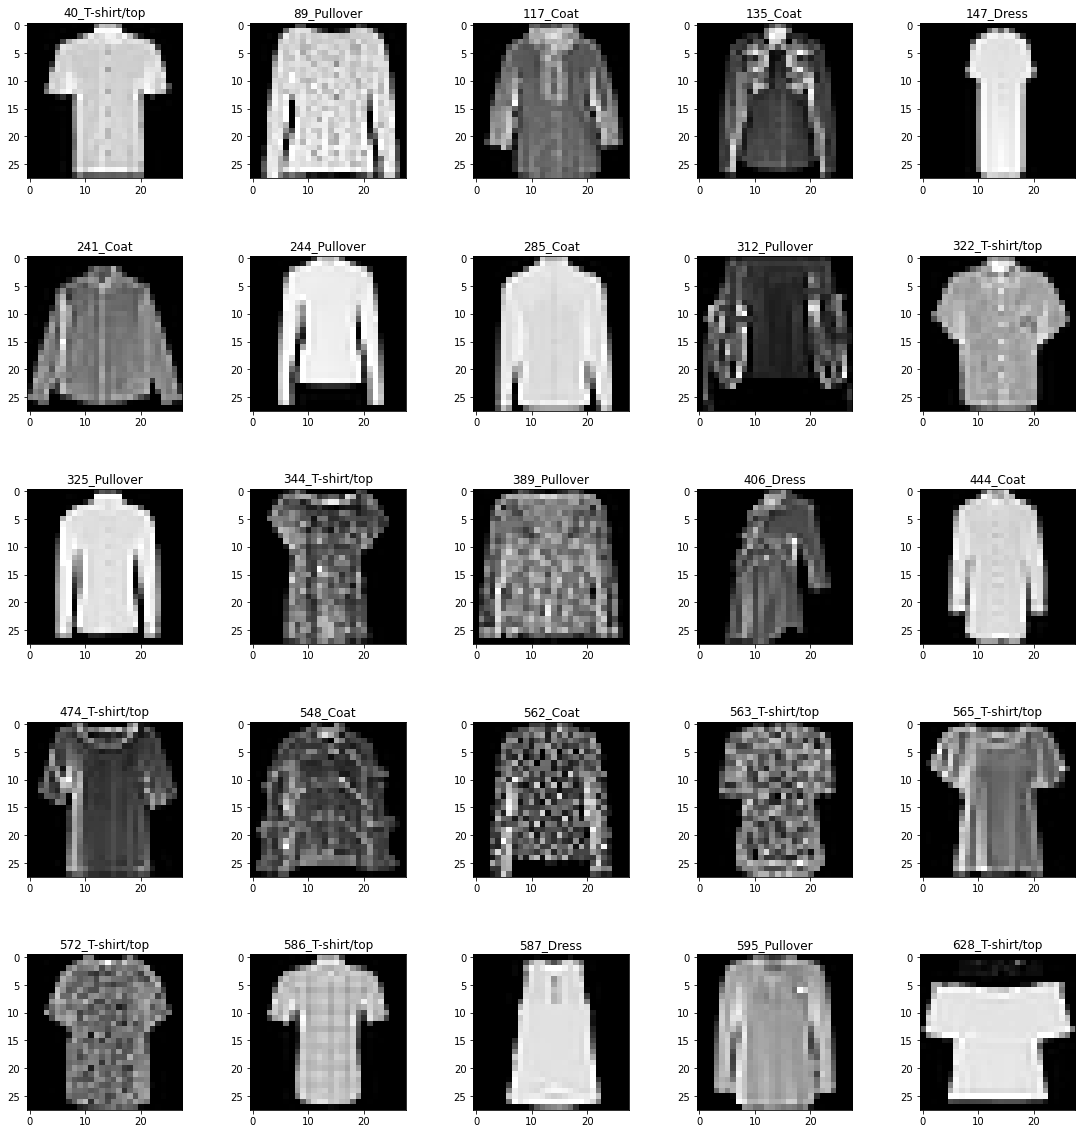

In [94]:
fig, axs = plt.subplots(5,5, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for j in range(25):
    i=shirt_wrong_ind[j]
    axs[j].imshow(Fmnist_test[i][0].numpy().reshape((28,28)), cmap='gray')
    axs[j].set_title(str(i)+'_'+labels_f[y_pred[i].item()])

In [0]:
# Кажется, что сложный класс
# Конец решения